# Initialization and API Functions

## Initialize Packages

In [4]:
# EE4211 Data Science for the Internet of Things
# Final Project
# Question 1 due 29 October 2023
# Question 2 due 9 November 2023
# Question 3 due 17 November 2023

# Import widely used packages.
import numpy as np
import pandas as pd
import json
import requests
import random
import time
import os
from dateutil.parser import parse

json_path = './json_files'
heatmaps_path = './heatmaps'

## API Functions

In [2]:
# Function for API calls (without saving to JSON file).
# Will run for a max of max_num_tries times.

def get_df(year, month, day, hour, minute, second):
  max_num_tries = 5
  num_tries = 0
  while num_tries < max_num_tries:
    try:
      # Get carpark information for one instance.
      site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
      # print(f'API call from: {site}')
      response_API = requests.get(site)
      data = response_API.text
      data = json.loads(data)
      timestamp = data["items"][0]["timestamp"]
      print(f'Timestamp Received from API Call: {timestamp}')

      # Process data.
      data = data["items"][0]["carpark_data"]
      df = pd.json_normalize(data)
      for heading in ("total_lots","lot_type","lots_available"):
          df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
      df = df.drop(["carpark_info"], axis=1)

    except Exception as e:
      num_tries += 1
      print(f'Exception found: {e}. Retrying ({num_tries}/{max_num_tries})...')

    else:
      return df
  print(f'Could not get data after {max_num_tries}. Stopping...')

In [3]:
# Function to download num_months worth of data in min_interval minute intervals.

def get_json(start_month=1, num_months=1, minute_interval=30):
  year = "2022"  # Set default year to 2022.
  month = str(start_month)
  day = "1"  # Set default day to 1st of the month.
  hour = "1" # Set default hour to 01:00hrs.
  minute = "00"
  second = "0"

  months_dct = {
    '1': 31,
    '2': 28,
    '3': 31,
    '4': 30,
    '5': 31,
    '6': 30,
    '7': 31,
    '8': 31,
    '9': 30,
    '10': 31,
    '11': 30,
    '12': 31
  }

  data = []
  full_list = []
  max_num_tries = 5
  num_tries = 0
  initial_month = month
  count = 0

  exit_flag = False

  while int(month) < int(initial_month) + num_months:
    while int(day) <= months_dct[month]:
      while int(hour) < 24:
        while int(minute) < 60:
          while num_tries < max_num_tries and not exit_flag:
            try:
              # Get carpark information for one instance.
              site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
              response_API = requests.get(site)
              data = response_API.text
              data = json.loads(data)
              timestamp = data["items"][0]["timestamp"]
              print(f'Timestamp Received from API Call: {timestamp}')
            except Exception as e:
              num_tries += 1
              print(f'Exception found: {e}. Retrying ({num_tries}/{max_num_tries})...')
              if num_tries >= max_num_tries:
                exit_flag = True
                print(f'Max retries reached! Stopping...')
            else:
              num_tries = 0
              # Process data.
              count += 1
              data = data["items"]
              full_list.append(data)
              minute = str(int(minute) + minute_interval)
              break
        if exit_flag:
          break
        minute = '1'
        hour = str(int(hour) + 1)
        print(f'Current Hour = {hour}')
      if exit_flag:
        break
      hour = '1'
      day = str(int(day) + 1)
      print(f'Current Day = {day}')
    if exit_flag:
      break
    day = '1'
    month = str(int(month) + 1)
  print(f'Current Month = {month}')

  if not exit_flag:
    print(f'Finished iterating!')
  else:
    print(f'Data was not scraped!')

  if full_list and not exit_flag:
      filepath = f"{json_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"
      with open(filepath, 'w') as fp:
        json.dump(full_list, fp, indent=4)
        print('File created.')
      return filepath
  else:
      return None

In [4]:
# Example:
# get_json(2, 30)
# will get 2 months of data at 30 minute intervals.

---

# Question 3: Group Proposed Project

**Project Proposal: Carpark Fullness Prediction Near Food Places**

Our team will explore advanced methods of Machine Learning to deal with the carpark availability data and make it useful for users by predicting carpark fullness near hawker centres in Singapore.

We will be testing methods such as Ensembling and Boosting to make a robust prediction model.

To increase stability and reduce variability in our models, we will use 5 months of training data (Jul 2022 - Nov 2022) and 1 month for our test data (Dec 2022).



## Question 3 Code

### Import Packages

In [2]:
# Imports for Question 3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Set a seed for reproducibility
seed = 4204
np.random.seed(seed)

# Ensembling
from sklearn.ensemble import StackingRegressor

# Support Vector Regression
from sklearn.svm import SVR

# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Regression Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

### Part 1: Find The Best Model to Use for our Data

We will be exploring different types of Ensembling, namely Bagging and Boosting, in this section to determine which model would be suitable for our predictions.

In [8]:
# Get training and test datasets
# Check for JSON file. If it does not exist, create it.

# Parameters for API Call.
start_months = ['7', '8', '9', '10', '11', '12']
num_months = 1
minute_interval = 60

for start_month in start_months:
  # Write into filesystem as we can reuse in future questions and is also a long process to get the data.
  path = f"{json_path}/ee4211_data_{start_month}_{num_months}_{minute_interval}.json"

  # If file does not exist, call API and create one.
  if (not os.path.exists(path)):
    print(f"Creating json starting at month {start_month} for {num_months} month at {minute_interval} min intervals.")
    json = get_json(start_month, num_months, minute_interval)
    if json == None:
      raise Exception("Creating json failed.")
  else:
    print(f'JSON at path ({path}) present.')

JSON at path (./json_files/ee4211_data_7_1_60.json) present.
JSON at path (./json_files/ee4211_data_8_1_60.json) present.
JSON at path (./json_files/ee4211_data_9_1_60.json) present.
JSON at path (./json_files/ee4211_data_10_1_60.json) present.
JSON at path (./json_files/ee4211_data_11_1_60.json) present.
JSON at path (./json_files/ee4211_data_12_1_60.json) present.


#### 1.1 Load Data
Obtain Training Data: Jul 2022 to Nov 2022

Obtain Test Data: Dec 2022

In [9]:
def process_parking_data(df_load):
  data_points = []

  for timestamp in range(df_load.shape[0]):
    data = df_load[0][timestamp]['carpark_data']
    # Convert list to dataframe.
    df = pd.DataFrame(data)

    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    # Data clean on df.
    df.dropna(inplace = True)

    total_lots_sum = 0
    lots_available_sum = 0

    for i in range(1, len(df['total_lots'])):
      lots_available_sum += int(df['lots_available'][i])
      total_lots_sum += int(df['total_lots'][i])

    # Calculate the ratio.
    ratio = lots_available_sum / total_lots_sum

    # Save the data points.
    time = df_load[0][timestamp]['timestamp']
    data_points.append((time, ratio))

  # Parse the timestamp and ratio into separate lists.
  dates, times, ratios = [], [], []
  for timestamp, ratio in data_points:
      # Parse the timestamp with dateutil's parse function.
      dt = parse(timestamp)
      # Extract date and time
      dates.append(dt.strftime('%Y-%m-%d'))
      times.append(dt.strftime('%H:%M'))
      ratios.append(ratio)

  # Create a DataFrame.
  df = pd.DataFrame({
      'date': dates,
      'time': times,
      'ratio': ratios
  })

  return df

In [11]:
# Load Training Data
# Jul 2022 - Nov 2022
df_data_jul = pd.read_json(f'{json_path}/ee4211_data_7_1_60.json')
df_data_aug = pd.read_json(f'{json_path}/ee4211_data_8_1_60.json')
df_data_sep = pd.read_json(f'{json_path}/ee4211_data_9_1_60.json')
df_data_oct = pd.read_json(f'{json_path}/ee4211_data_10_1_60.json')
df_data_nov = pd.read_json(f'{json_path}/ee4211_data_11_1_60.json')

# Load Test Data
# December 2022
df_test_dec = pd.read_json(f'{json_path}/ee4211_data_12_1_60.json')

In [12]:
# Get datasets.
df_train_models = pd.concat([df_data_jul, df_data_aug, df_data_sep, df_data_oct, df_data_nov], ignore_index = True)
df_train_models = process_parking_data(df_train_models)
df_test_models = process_parking_data(df_test_dec)

df_train_models

date   time     ratio
0     2022-07-01  00:59  0.465898
1     2022-07-01  02:00  0.458253
2     2022-07-01  03:00  0.455494
3     2022-07-01  04:00  0.457910
4     2022-07-01  05:00  0.458170
...          ...    ...       ...
3514  2022-11-30  19:00  0.604489
3515  2022-11-30  20:00  0.561720
3516  2022-11-30  21:00  0.533799
3517  2022-11-30  22:00  0.511329
3518  2022-11-30  23:00  0.488856

[3519 rows x 3 columns]

In [13]:
# Function to create lagged features.
def create_lagged_features(df, n_lags):
    lagged_dfs = [df]  # Start with the original DataFrame in a list.
    for n in range(1, n_lags + 1):
        lagged_df = df[['ratio']].shift(n)  # Create a DataFrame of shifted values.
        lagged_df.rename(columns={'ratio': f'lag_{n}h'}, inplace=True)  # Rename the shifted column.
        lagged_dfs.append(lagged_df)  # Add the new DataFrame to the list.

    # Concatenate all the DataFrames in the list.
    df_with_lags = pd.concat(lagged_dfs, axis=1)
    return df_with_lags

In [14]:
# Merge the date and time columns and convert to datetime.
df_train_models['datetime'] = pd.to_datetime(df_train_models['date'] + ' ' + df_train_models['time'])
df_test_models['datetime'] = pd.to_datetime(df_test_models['date'] + ' ' + df_test_models['time'])

# Set the datetime as the index.
df_train_models = df_train_models.set_index('datetime')
df_test_models = df_test_models.set_index('datetime')

# Create lagged features for the last 10 days.
n_lags = 10 * 24
df_train_models = create_lagged_features(df_train_models, n_lags)
df_test_models = create_lagged_features(df_test_models, n_lags)

# Drop rows with NaN values that were created by shifting.
df_train_models.dropna(inplace=True)
df_test_models.dropna(inplace=True)

# The new feature matrix includes the lagged features plus the hour and day of week.
df_train_models['hour'] = df_train_models.index.hour
df_train_models['day_of_week'] = df_train_models.index.dayofweek
df_test_models['hour'] = df_test_models.index.hour
df_test_models['day_of_week'] = df_test_models.index.dayofweek

X_train = df_train_models.drop(['date', 'time', 'ratio'], axis=1)
y_train = df_train_models['ratio']

X_test = df_test_models.drop(['date', 'time', 'ratio'], axis=1)
y_test = df_test_models['ratio']

#### 1.2 Random Forest Ensemble

Regression Metrics:
[Train] MSE: 6.402233720249221e-06, R2: 0.9990821988204088
[Cross Validation on Train] Mean R2 = 0.9948, Std = 0.0021
[Test] MSE: 7.641169090923836e-05, R2: 0.9859575621806412


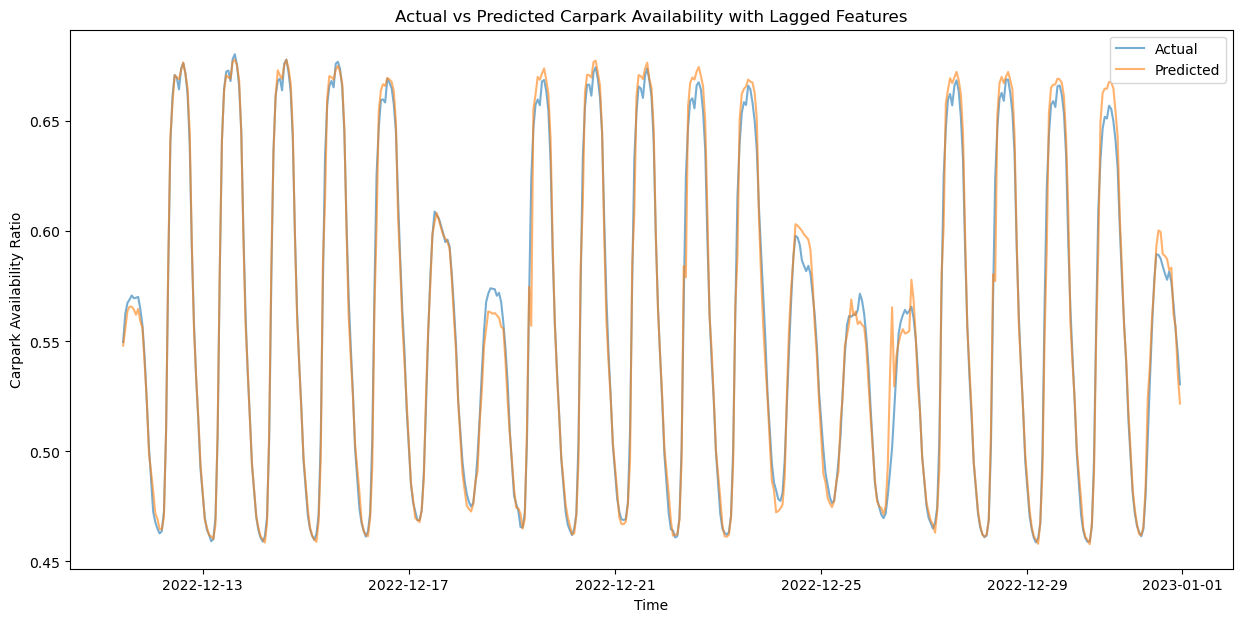

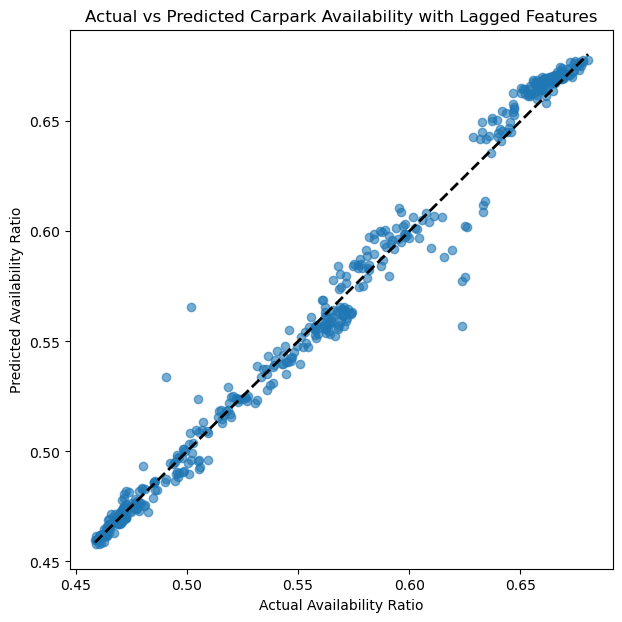

In [15]:
# Random Forest Forecast

# Train the model.
model = RandomForestRegressor(n_estimators=50, max_depth=10) # Hyper-parameter Tuning.
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_dt = scores_dt.mean()
std_scores_dt = scores_dt.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.3 Decision Tree and SVR Ensemble

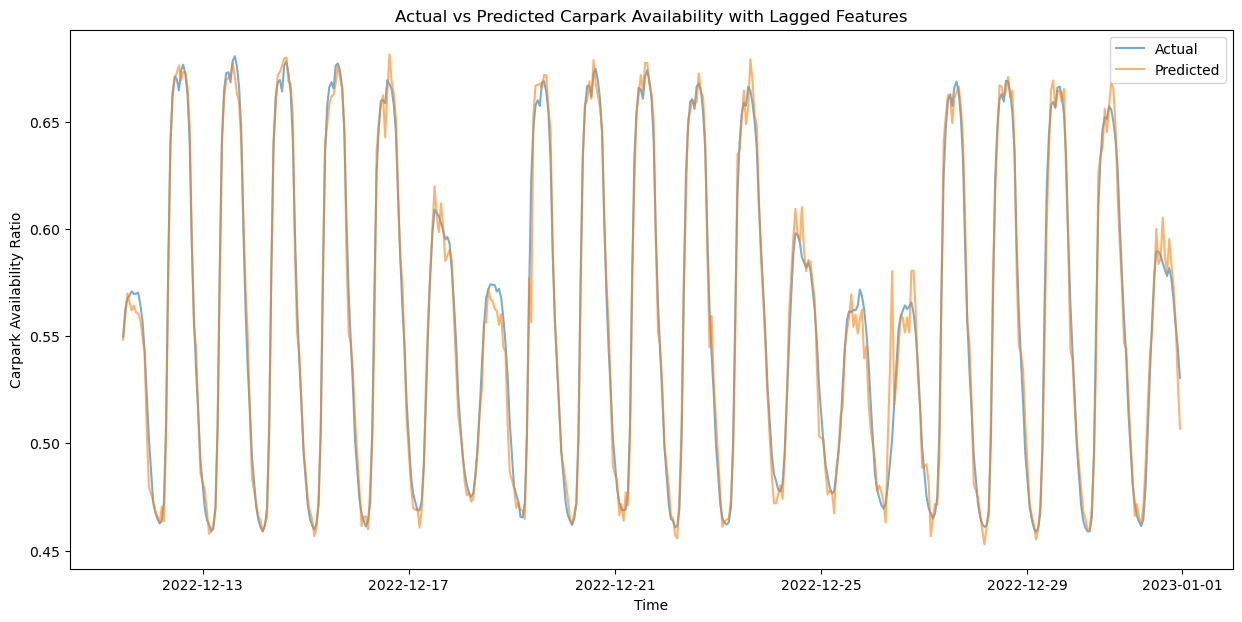

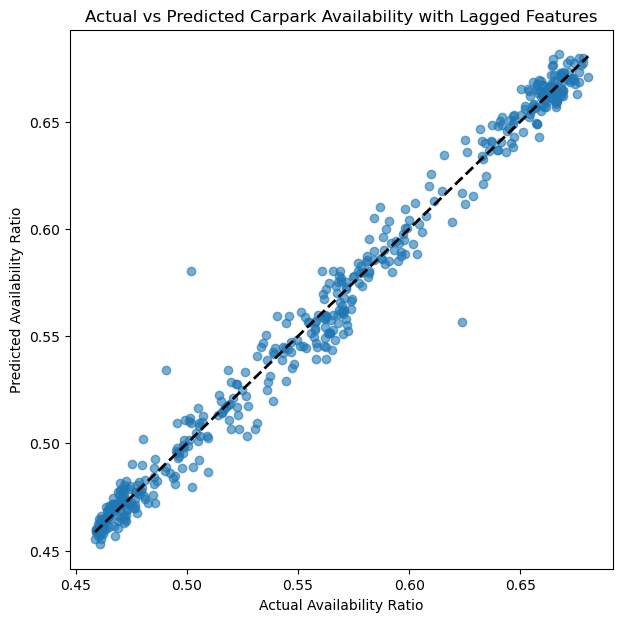

In [16]:
# Decision Tree and SVR Forecast
# Ensembling better visualised

# Train the models.
# 1 SVR and 1 DT Regressor for the ensemble
dtr = DecisionTreeRegressor(random_state=0,max_depth=10,min_samples_split=2) # Hyper-parameter Tuning.
dtr.fit(X_train, y_train)
svr = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.01) # Hyper-parameter Tuning.
svr.fit(X_train, y_train)

# Evaluate the Model.
predictions_train_dtr = dtr.predict(X_train)
predictions_train_svr = svr.predict(X_train)
predictions_train = np.round((predictions_train_dtr + predictions_train_svr) / 2, decimals=6)

predictions_test_dtr = dtr.predict(X_test)
predictions_test_svr = svr.predict(X_test)
predictions_test = np.round((predictions_test_dtr + predictions_test_svr) / 2, decimals=6)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.4 AdaBoostRegressor on Decision Tree


Regression Metrics:
[Train] MSE: 3.4627357917446028e-06, R2: 0.9995035946619343
[Cross Validation on Train] Mean R2 = 0.9962, Std = 0.0016
[Test] MSE: 7.448248091016245e-05, R2: 0.9863120997014073


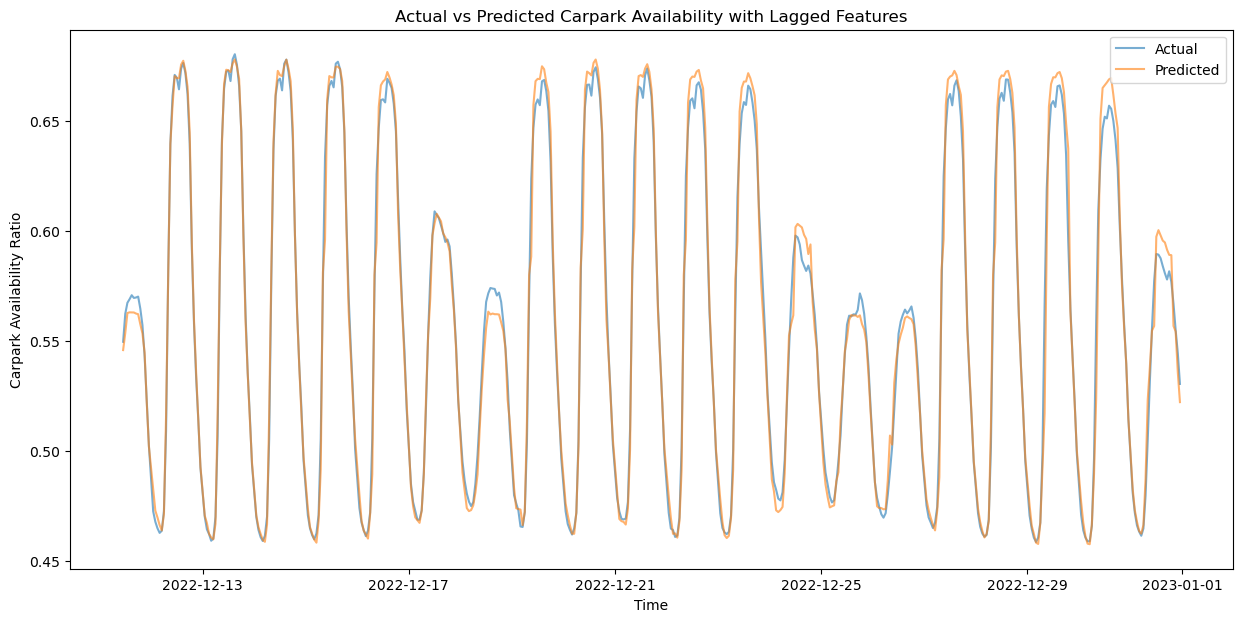

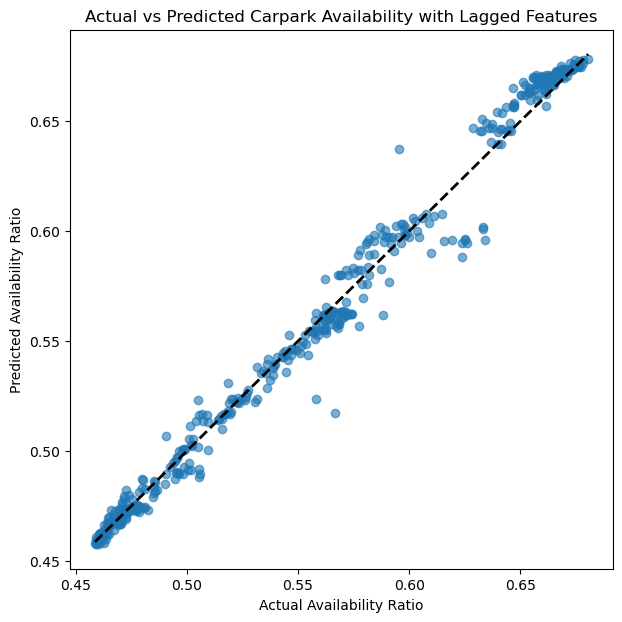

In [17]:
# AdaBoost on DecisionTreeRegressor

# Train the model.
# Create a Decision Tree (DT) model as the 'weak' model (drop the max depth as the initial model is supposed to be not that good yes?)
# Conduct AdaBoost on DT
weak_model = DecisionTreeRegressor(random_state=0,max_depth=8,min_samples_split=2) # Hyper-parameter Tuning.
model = AdaBoostRegressor(weak_model, n_estimators=50, random_state=0)
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Perform 5-fold cross-validation to test for overfitting.
k = 5
scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
mean_scores_dt = scores_dt.mean()
std_scores_dt = scores_dt.std()

print('Regression Metrics:')
print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
print('======================================================================')

# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.5 AdaBoostRegressor on SVR

In [ ]:
# AdaBoost on SupportVectorRegressor

# Train the model.
# Create a SVR model as the 'weak' model
# Conduct AdaBoost on SVR
weak_model = SVR(kernel="linear", C=100, gamma=0.1, epsilon=0.01) # Hyper-parameter Tuning.
model = AdaBoostRegressor(weak_model, n_estimators=2, random_state=0)
model.fit(X_train, y_train)

# Evaluate the Model.
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Calculate metrics.
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)


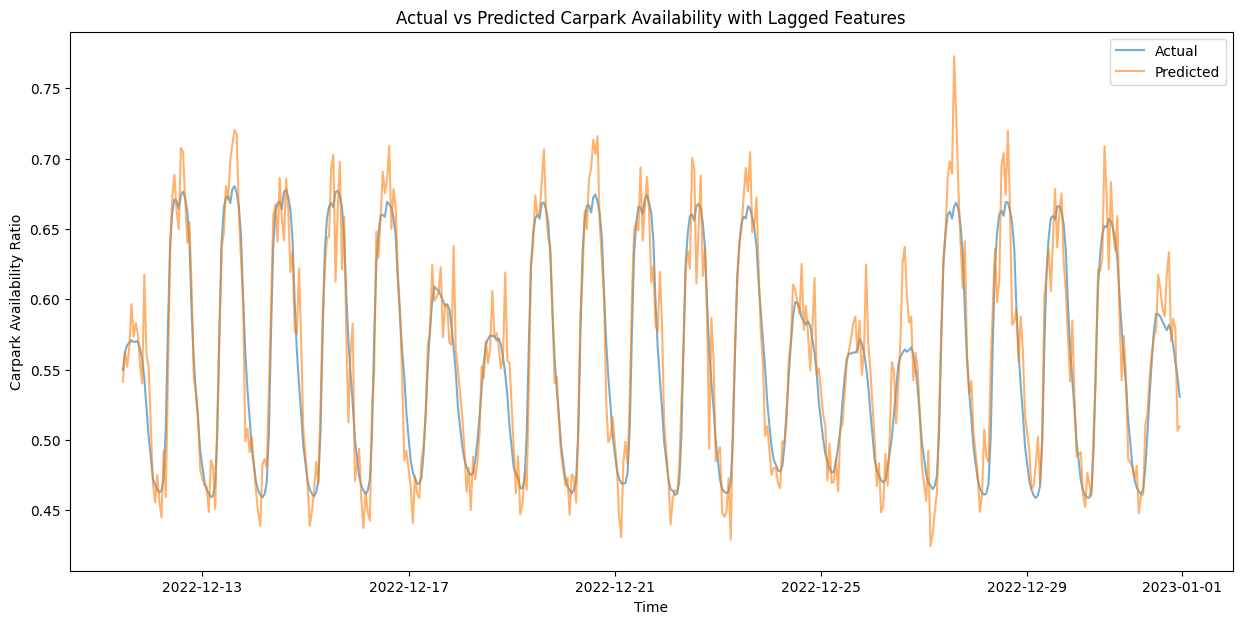

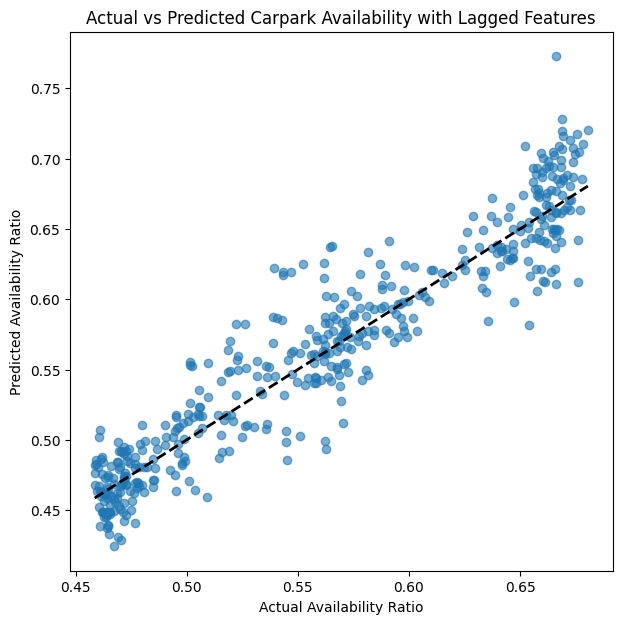

In [ ]:
# Visualization.
# (i) Time series plot of the actual and predicted hourly values.
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(X_test.index, predictions_test, label='Predicted', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Carpark Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.legend()
plt.show()

# (ii) Scatter plot of actual vs predicted hourly values.
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predictions_test, alpha=0.6)
plt.xlabel('Actual Availability Ratio')
plt.ylabel('Predicted Availability Ratio')
plt.title('Actual vs Predicted Carpark Availability with Lagged Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

#### 1.6 Model Decision

In our project, we decided to use the Random Forest model for predicting car park availability. Our choice was based on finding the best balance between several key factors: how well the model performs, how complex it is, and how long it takes to train it. Initially, we considered several models, including the Support Vector Regression (SVR). Although SVR showed slightly better performance in some aspects, it took significantly longer to train. This was a major drawback for us because we needed a model that could be trained relatively quickly. Since we aim to run models on each car park separately to capture their unique characteristics and trends, our project will involve working with a large amount of unaggregated data from individual car parks. 

As a result, the speed of training is crucial in our context. We want to quickly analyze data and make timely predictions. The Random Forest model stood out because it combines the simplicity and speed of decision trees with improved accuracy. It works by creating multiple decision trees and combining their results to make more accurate predictions. This approach helps in understanding different patterns in car park usage across various locations and times.

In summary, we chose the Random Forest model because it provides a good balance of accuracy and speed, is relatively straightforward to implement, and effectively handles the diverse and unaggregated nature of our car park data. This choice allows us to efficiently analyze car park trends and make accurate predictions, which is essential for our project’s success.








### Part 2: Get Carparks Near Hawker Centres Data
Using data we collected on Carpark Location and Hawker Centres near them (*nearby.json*), we will check for carparks that are in the original dataset that are near Hawker Centres and store them in a JSON file.

In [18]:
# Identify nearby carparks within 200m of hawker centre.

import math
import json
import os

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Coordinates in decimal degrees (e.g. 43.60, -79.49)
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Convert latitude and longitude from degrees to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance


tolerance = 0.4
nearby = []

if(not os.path.exists(f"{json_path}/nearby.json")):

  with open(f"{json_path}/carpark.json", "r") as file:
      carpark_json = json.load(file)

  with open(f"{json_path}/HawkerCentreData_formatted.json", "r") as file:
      hawker_center_json = json.load(file)

  carparks = carpark_json["value"]
  for hawker_center in hawker_center_json:
      name = hawker_center["hawker_name"]
      hawker_location = hawker_center["coordinates"]
      locs = hawker_location.split(" ")
      coord1 = (float(locs[0]), float(locs[1]))
      # print(coord1)
      for carpark in carparks:

          carparkId = carpark["CarParkID"]
          carpark_location = carpark["Location"]
          carpark_name = carpark["Development"]
          locs2 = carpark_location.split(" ")
          coord2 = (float(locs2[0]), float(locs2[1]))
          # print(coord2)

          distance = haversine(coord1, coord2)
          is_1_km_apart = abs(distance - 0.2) < tolerance  # tolerance could be a small value like 10 to allow for some margin
          if (is_1_km_apart):
              nearby.append({"Id" : carparkId, "carpark": carpark_name , "location" : carpark_location, "hawker": name, "distance": distance})
          # print(f"{carparkId} is nearby {name} with dist {distance}")

  with open(f"{json_path}/nearby.json", "r") as file:
      json.dump(nearby, file, indent=4)

else:
  print("Json for nearby carparks has been generated before")

Json for nearby carparks has been generated before


In [19]:
df_nearby_data = pd.read_json(f"{json_path}/nearby.json")
df_jul_data = pd.read_json(f'{json_path}/ee4211_data_7_1_60.json')

In [20]:
hawker_nearby_fp = f'{json_path}/hawker_nearby.json'

if os.path.isfile(hawker_nearby_fp):
  print(f'Existing hawker_nearby.json file found at {hawker_nearby_fp}')
else:
  hawker_dict = {}
  for carpark in df_jul_data.iloc[0][0]["carpark_data"]:
    id = carpark['carpark_number']
    if id in df_nearby_data['Id'].unique():
      hawker_name = df_nearby_data[df_nearby_data['Id'] == id]['hawker'].iloc[0]
      carpark_add = df_nearby_data[df_nearby_data['Id'] == id]['carpark'].iloc[0]
      carpark_coord = df_nearby_data[df_nearby_data['Id'] == id]['location'].iloc[0] # Carpark coord
      data = {
          'carpark_id': id,
          'carpark_add': carpark_add,
          'carpark_coord': carpark_coord
      }
      if hawker_dict.get(hawker_name, 0):
        hawker_dict[hawker_name].append(data)
      else:
        hawker_dict[hawker_name] = [data]
  print(hawker_dict)
  with open(hawker_nearby_fp, 'w') as f:
    json.dump(hawker_dict, f, indent=4)

Existing hawker_nearby.json file found at ./json_files/hawker_nearby.json


#### 2.1 Selecting Carparks

Based on the data generated from the code above (in *hawker_nearby.json*), we will be using the following data collected as our proof of concept:

```
"Yishun Ring Road Blk 104/105 (Chong Pang Market and Food Centre)":
[
        {
            "carpark_id": "Y8",
            "carpark_add": "BLK 731/746 YISHUN STREET 71,72/AVENUE 5",
            "carpark_coord": "1.4294449190702871 103.83127807040323"
        },
        {
            "carpark_id": "Y3",
            "carpark_add": "BLK 112/120 YISHUN RING ROAD",
            "carpark_coord": "1.4347114221949966 103.82888652134125"
        },
        {
            "carpark_id": "Y3M",
            "carpark_add": "BLK 115A/115B/115C YISHUN RING ROAD",
            "carpark_coord": "1.4335446820824216 103.82746981634773"
        },
        {
            "carpark_id": "Y4",
            "carpark_add": "BLK 121/143 YISHUN STREET 11/RING ROAD",
            "carpark_coord": "1.4347516057906717 103.83150986637463"
        },
        {
            "carpark_id": "Y7",
            "carpark_add": "BLK 701/716 & 701B YISHUN AVENUE 5",
            "carpark_coord": "1.4273018179334416 103.82745054301381"
        },
        {
            "carpark_id": "Y5",
            "carpark_add": "BLK 144/149 YISHUN STREET 11",
            "carpark_coord": "1.4311145317313538 103.83210758322952"
        },
        {
            "carpark_id": "Y58",
            "carpark_add": "162 YISHUN STREET 11",
            "carpark_coord": "1.432539248516593 103.83238250558868"
        },
        {
            "carpark_id": "Y1",
            "carpark_add": "BLK 101/102 YISHUN AVE 5",
            "carpark_coord": "1.4308445425594365 103.82803573858493"
        },
        {
            "carpark_id": "Y2",
            "carpark_add": "BLK 103/111 YISHUN RING ROAD",
            "carpark_coord": "1.4321665542852815 103.82805888962517"
        }
]
```



### Part 3: Extract 4 Months of Data for a Particular Carpark

We will extract the relevant data for a particular carpark from the 4 months of data that we got from our API calls on carpark availability.

#### 3.1: Load Data

In [21]:
df_train = pd.concat([df_data_jul, df_data_aug, df_data_sep, df_data_oct, df_data_nov], ignore_index = True)
df_test = df_test_dec

#### 3.2: Extract Data For Particular Carpark

In [23]:
def extract_parking_data(df_load, carpark_name, name="default"):
  filepath = f"{json_path}/parking_{carpark_name}_{name}.json"

  if os.path.exists(filepath):
    print(f"File at path ({filepath}) already exists, loading from file.")
    df = pd.read_json(filepath)
    return df

  data_points = []

  for timestamp in range(df_load.shape[0]):
    data = df_load[0][timestamp]['carpark_data']
    # Convert list to dataframe.
    df = pd.DataFrame(data)

    for heading in ("total_lots","lot_type","lots_available"):
      for carpark in df_load[0][timestamp]['carpark_data']:
        if carpark["carpark_number"] == carpark_name:
          # Calculate the ratio.
          ratio = float(carpark["carpark_info"][0]['lots_available']) / float(carpark["carpark_info"][0]['total_lots'])
          df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    # Data clean on df.
    df.dropna(inplace = True)

    # Total Calculation
    total_lots_sum = 0
    lots_available_sum = 0

    if 'total_lots' not in df:
      print(f"{carpark_name} not present")
      return

    # Save the data points.
    time = df_load[0][timestamp]['timestamp']
    data_points.append((time, ratio))

  # Parse the timestamp and ratio into separate lists.
  dates, times, ratios = [], [], []
  for timestamp, ratio in data_points:
      # Parse the timestamp with dateutil's parse function.
      dt = parse(timestamp)
      # Extract date and time
      dates.append(dt.strftime('%Y-%m-%d'))
      times.append(dt.strftime('%H:%M'))
      ratios.append(ratio)

  # Create a DataFrame.
  df = pd.DataFrame({
      'date': dates,
      'time': times,
      'ratio': ratios
  })


  df.to_json(filepath)

  return df

### Part 4: Generate Training Set from Extracted Data
We will now generate the train and test sets from the extracted data which we can use for our prediction model.

In [24]:
def gen_sets(dataframe_train, dataframe_test):
  dataframe_train['date'] = dataframe_train['date'].astype(str)
  dataframe_train['time'] = dataframe_train['time'].astype(str)
  dataframe_test['date'] = dataframe_test['date'].astype(str)
  dataframe_test['time'] = dataframe_test['time'].astype(str)

  # Generate test and train sets for model
  # Merge the date and time columns and convert to datetime.
  dataframe_train['datetime'] = pd.to_datetime(dataframe_train['date'] + ' ' + dataframe_train['time'])
  dataframe_test['datetime'] = pd.to_datetime(dataframe_test['date'] + ' ' + dataframe_test['time'])

  # Set the datetime as the index.
  dataframe_train = dataframe_train.set_index('datetime')
  dataframe_test = dataframe_test.set_index('datetime')

  # Create lagged features for the last 10 days.
  n_lags = 10 * 24
  dataframe_train = create_lagged_features(dataframe_train, n_lags)
  dataframe_test = create_lagged_features(dataframe_test, n_lags)

  # Drop rows with NaN values that were created by shifting.
  dataframe_train.dropna(inplace=True)
  dataframe_test.dropna(inplace=True)

  # The new feature matrix includes the lagged features plus the hour and day of week.
  dataframe_train['hour'] = dataframe_train.index.hour
  dataframe_train['day_of_week'] = dataframe_train.index.dayofweek
  dataframe_test['hour'] = dataframe_test.index.hour
  dataframe_test['day_of_week'] = dataframe_test.index.dayofweek

  X_train = dataframe_train.drop(['date', 'time', 'ratio'], axis=1)
  y_train = dataframe_train['ratio']

  X_test = dataframe_test.drop(['date', 'time', 'ratio'], axis=1)
  y_test = dataframe_test['ratio']

  return (X_train, y_train, X_test, y_test)

# (X_train, y_train, X_test, y_test) = gen_sets(dataframe_train, dataframe_test)

### Part 5: Predict Using Model
Based on the train and test sets, conduct Random Forest Forecasting.

In [25]:
def RandomForest(X_train, y_train, X_test, y_test):
  # Random Forest Forecast

  # Train the model.
  model = RandomForestRegressor(n_estimators=50, max_depth=5) # Hyper-parameter Tuning.
  model.fit(X_train, y_train)

  # Evaluate the Model.
  predictions_train = model.predict(X_train)
  predictions_test = model.predict(X_test)

  # Calculate metrics.
  mse_train = mean_squared_error(y_train, predictions_train)
  r2_train = r2_score(y_train, predictions_train)
  mse_test = mean_squared_error(y_test, predictions_test)
  r2_test = r2_score(y_test, predictions_test)

  # Perform 5-fold cross-validation to test for overfitting.
  k = 5
  scores_dt = cross_val_score(model, X_train, y_train, cv=k, scoring='r2')
  mean_scores_dt = scores_dt.mean()
  std_scores_dt = scores_dt.std()

  print('Regression Metrics:')
  print(f'[Train] MSE: {mse_train}, R2: {r2_train}')
  print(f"[Cross Validation on Train] Mean R2 = {mean_scores_dt:.4f}, Std = {std_scores_dt:.4f}")
  print(f'[Test] MSE: {mse_test}, R2: {r2_test}')
  print('======================================================================')

  return predictions_test

# pred_test = RandomForest(X_train, y_train, X_test, y_test)

In [26]:
def visualization(X_test, y_test, pred_test, carpark_name):
  # Visualization.
  # (i) Time series plot of the actual and predicted hourly values.
  plt.figure(figsize=(15, 7))
  plt.plot(X_test.index, y_test, label='Actual', alpha=0.6)
  plt.plot(X_test.index, pred_test, label='Predicted', alpha=0.6)
  plt.xlabel('Time')
  plt.ylabel('Carpark Availability Ratio')
  plt.title(f'Actual vs. Predicted Carpark Availability for {carpark_name}')
  plt.legend()
  plt.show()

  # (ii) Scatter plot of actual vs predicted hourly values.
  plt.figure(figsize=(7, 7))
  plt.scatter(y_test, pred_test, alpha=0.6)
  plt.xlabel('Actual Availability Ratio')
  plt.ylabel('Predicted Availability Ratio')
  plt.title(f'Actual vs. Predicted Carpark Availability for Carpark {carpark_name}')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
  plt.show()

# visualization(X_test, y_test, pred_test)

### Part 6: Using Predicted Data, Generate 24 Hour Parking Availability for that Carpark

From the predicted data generated by the Random Forest Ensemble model, calculate the 24-hour availability ratios for the particular carpark.

In [27]:
def gen_availability(pred_test, df_test, carpark_name):
  df_test = df_test.reset_index()  # Reset the index to make 'datetime' a column.
  pred_test = pd.DataFrame(pred_test, columns=['predictions'])  # Create a DataFrame for predictions.

  # Combine the DataFrames.
  df = pd.concat([df_test, pred_test], axis=1)
  df = df.drop(["ratio"], axis=1)
  # Data clean on df.
  df.dropna(inplace = True)

  ratios_list = []
  for index, row in df.iterrows():
    time = str(row['datetime'])
    hour = time[11:13]
    day = time[8:10]
    ratios_list.append((day, hour, row['predictions']))

  # Create New DataFrame to Contain Carpark Hourly Availability Ratios.
  df_new = pd.DataFrame(ratios_list, columns=['Day', 'Hour', 'Ratio'])
  df_new['Hour'] = pd.to_numeric(df_new['Hour'], errors='coerce')

  hourly_averages = df_new.groupby(['Hour'])['Ratio'].mean().reset_index()
  hourly_averages['Ratio'] = hourly_averages['Ratio'].apply(lambda x: round(x, 5))

  # Set 'Hour' as the index.
  hourly_averages = hourly_averages.set_index('Hour')

  # Reindex to include all hours (0 to 23).
  hourly_averages = hourly_averages.reindex(range(24))

  # Interpolate missing 'Ratio' values and fill any remaining NaNs.
  hourly_averages['Ratio'] = hourly_averages['Ratio'].interpolate().ffill().bfill()

  # Reset the index to make 'Hour' a column again.
  hourly_averages = hourly_averages.reset_index()

  carpark_data = hourly_averages[['Hour', 'Ratio']]

  x = []
  y = []

  # Plot Graph for Carpark.
  for index, row in carpark_data.iterrows():
      hour = row['Hour']
      availability = float(row['Ratio'])
      x.append(hour)
      y.append(availability)
  max_y = max(y)
  min_y = min(y)

  plt.plot(x, y, color='red', marker='o')
  plt.xticks(x)
  plt.xlabel('Hour of the Day')
  plt.ylabel('Ratio')
  plt.title(f'Ratio Against Time for Carpark {carpark_name}')
  plt.show()

  # Create the final DataFrame with carpark_name and hourly ratios.
  final_df = pd.DataFrame(columns=['carpark_name'] + [f'hour {i} ratio' for i in range(24)])
  ratios = [carpark_name] + hourly_averages['Ratio'].tolist()
  final_df.loc[0] = ratios

  return final_df

### Part 7: Run for the Selected Carparks

The following cell will run the above functions for the list of carparks selected in *Part 2.1*.

It will then plot the relevant graphs for that carpark which will explain:
- The model's suitability.
- The carpark availabilit ratios in a 24-hour estimate.

================================== Starting model generation for Carpark Y1... ==================================
File at path (./json_files/parking_Y1_train.json) already exists, loading from file.
File at path (./json_files/parking_Y1_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.004061229497988433, R2: 0.94265547812684
[Cross Validation on Train] Mean R2 = 0.9150, Std = 0.0149
[Test] MSE: 0.007516646188439889, R2: 0.9153410938430521


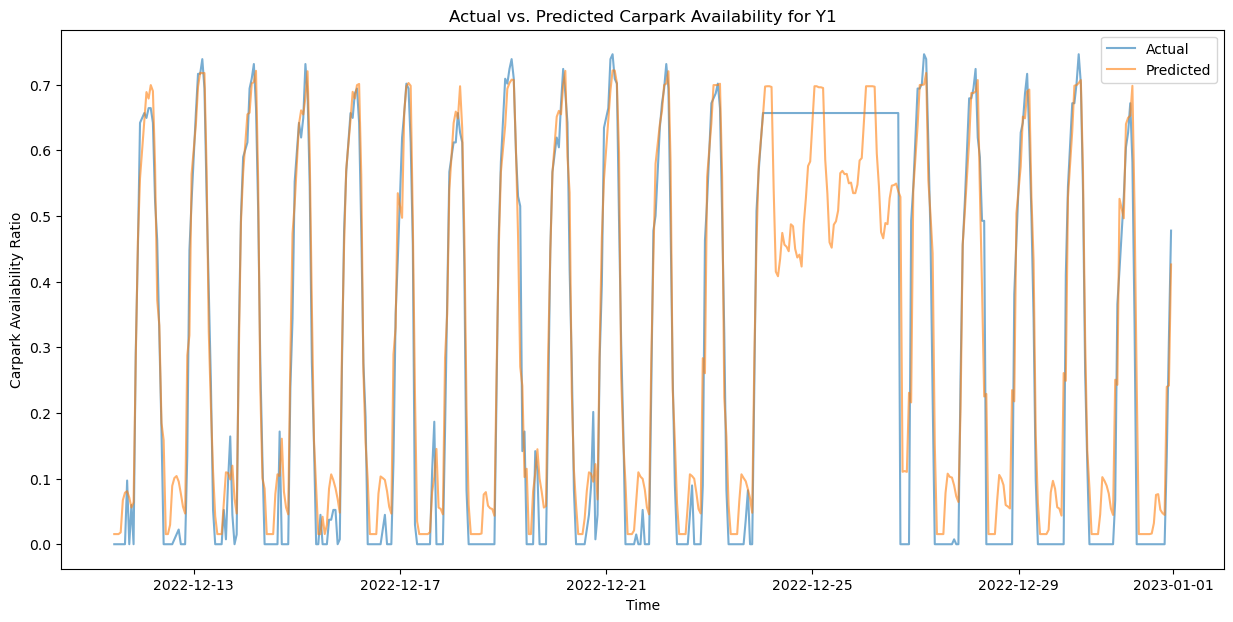

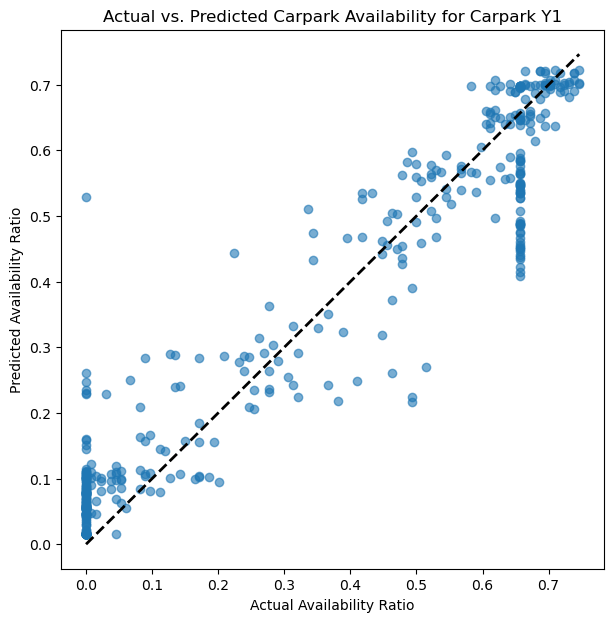

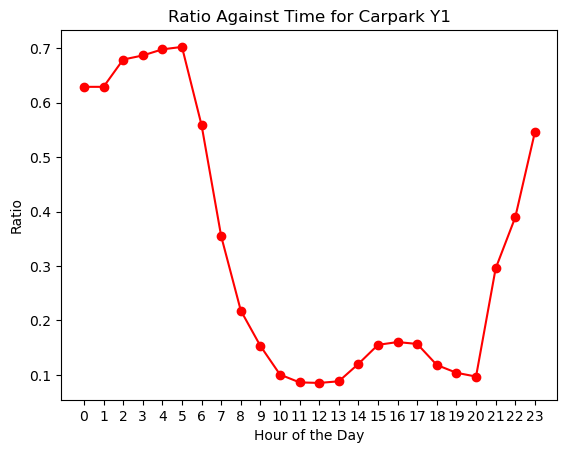

================================== Starting model generation for Carpark Y2... ==================================
File at path (./json_files/parking_Y2_train.json) already exists, loading from file.
File at path (./json_files/parking_Y2_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0013982046973452964, R2: 0.9039400687361066
[Cross Validation on Train] Mean R2 = 0.8690, Std = 0.0204
[Test] MSE: 0.0022537076789109485, R2: 0.8393005496518724


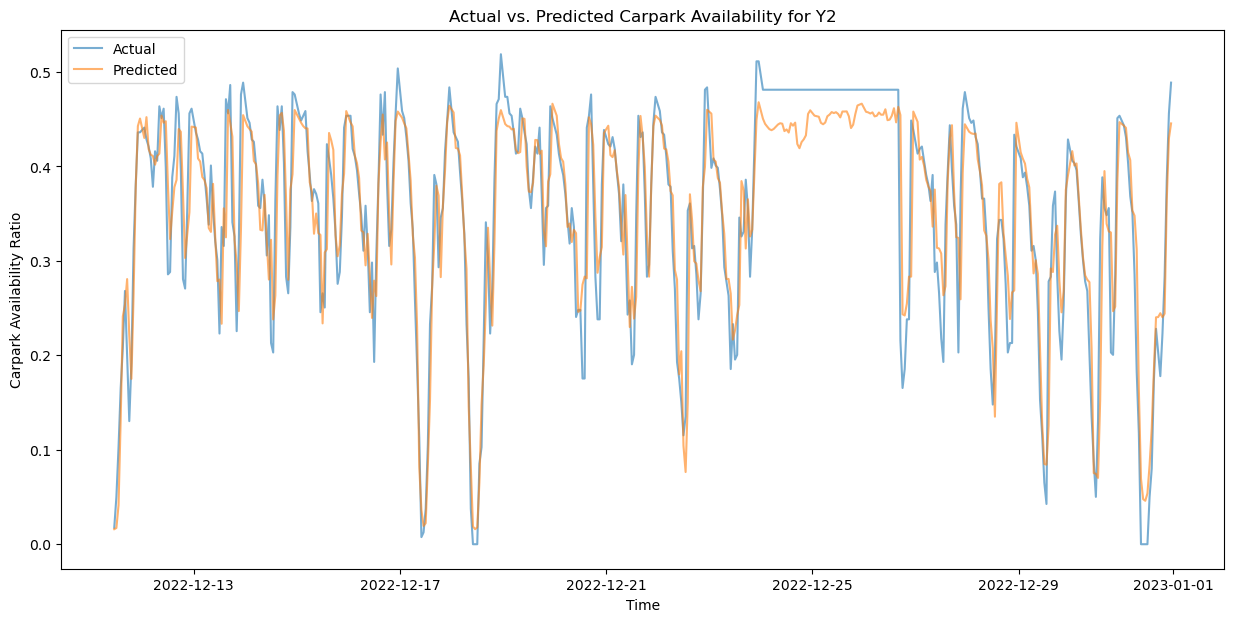

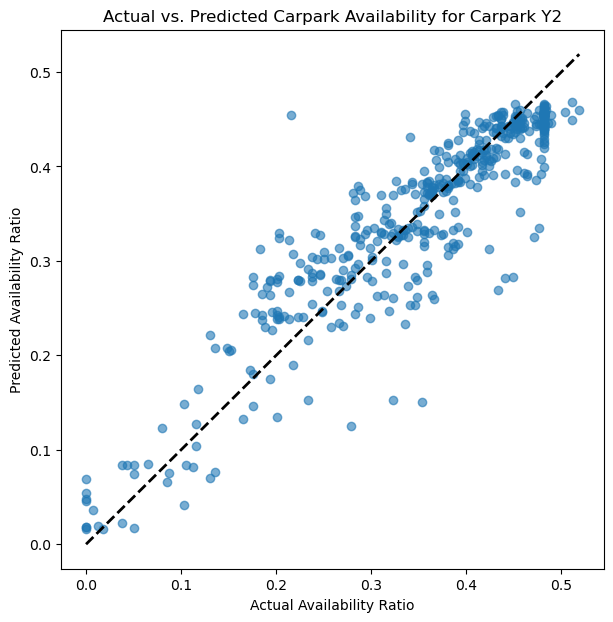

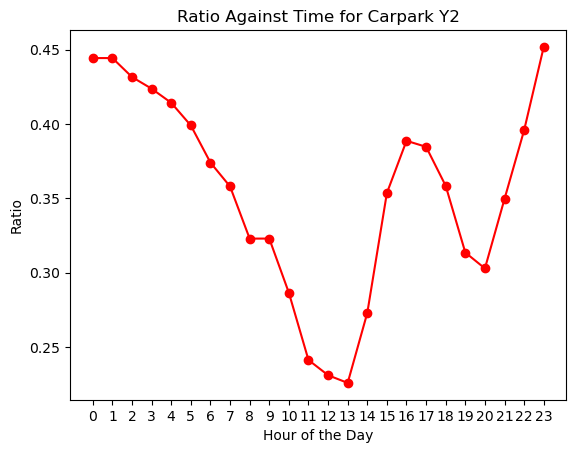

================================== Starting model generation for Carpark Y3... ==================================
File at path (./json_files/parking_Y3_train.json) already exists, loading from file.
File at path (./json_files/parking_Y3_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0006847451484368012, R2: 0.9754900691355742
[Cross Validation on Train] Mean R2 = 0.9592, Std = 0.0251
[Test] MSE: 0.0007419167866183989, R2: 0.9664627131860248


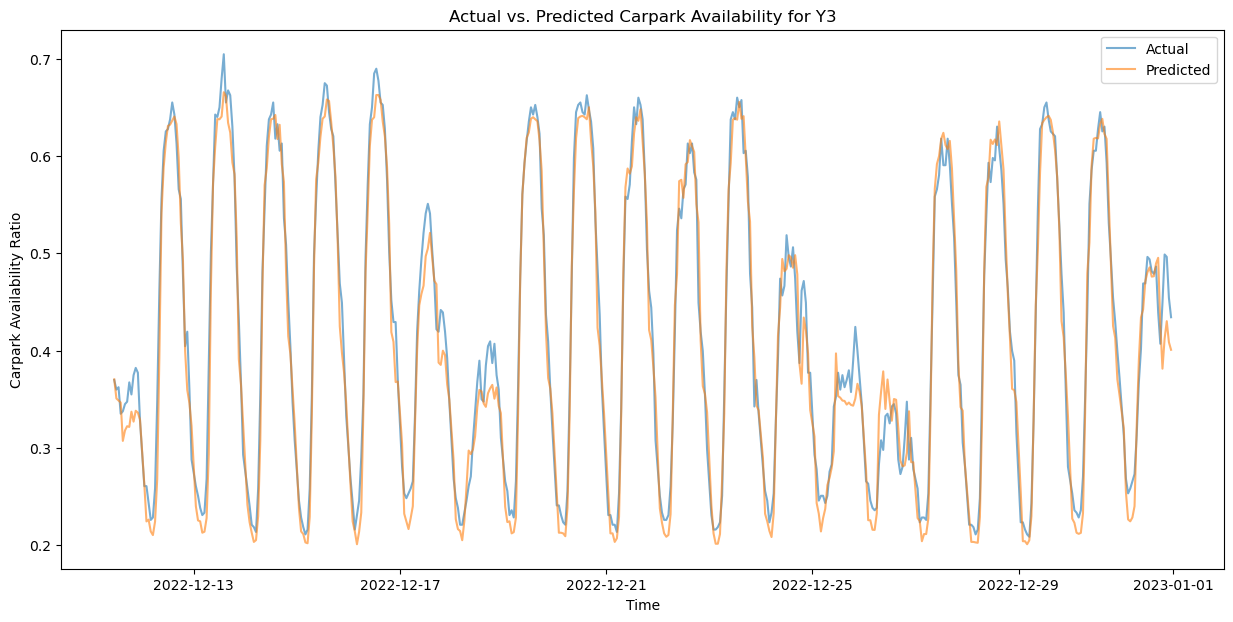

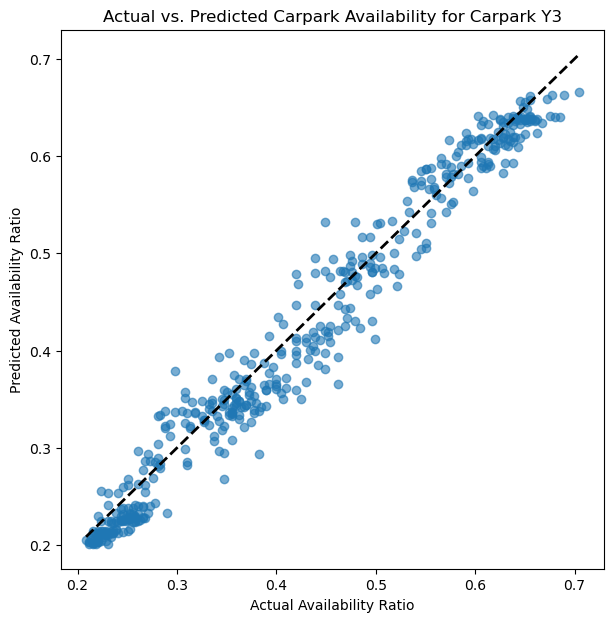

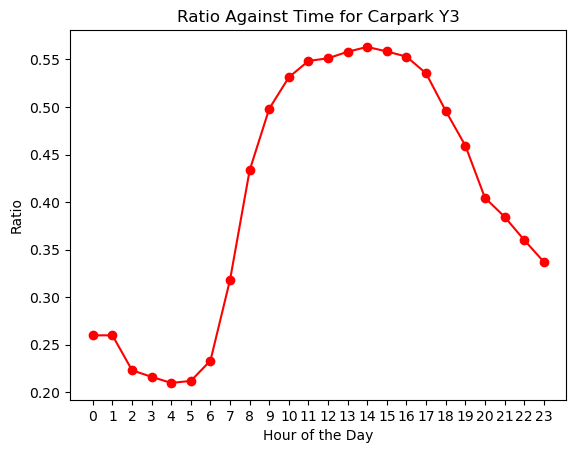

================================== Starting model generation for Carpark Y3M... ==================================
File at path (./json_files/parking_Y3M_train.json) already exists, loading from file.
File at path (./json_files/parking_Y3M_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0007720010211528825, R2: 0.9737001077079551
[Cross Validation on Train] Mean R2 = 0.9585, Std = 0.0108
[Test] MSE: 0.0009802268930516746, R2: 0.9541201049635398


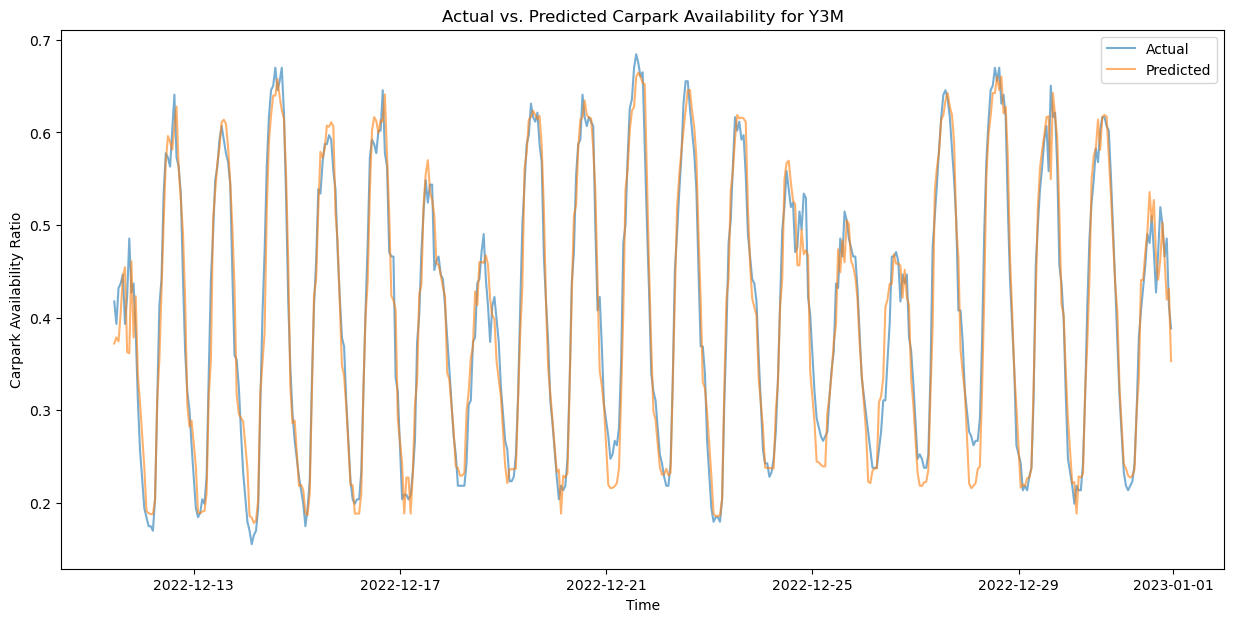

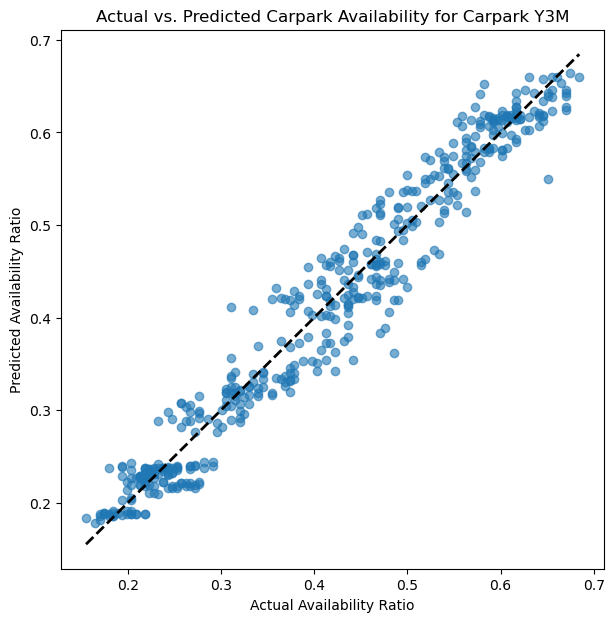

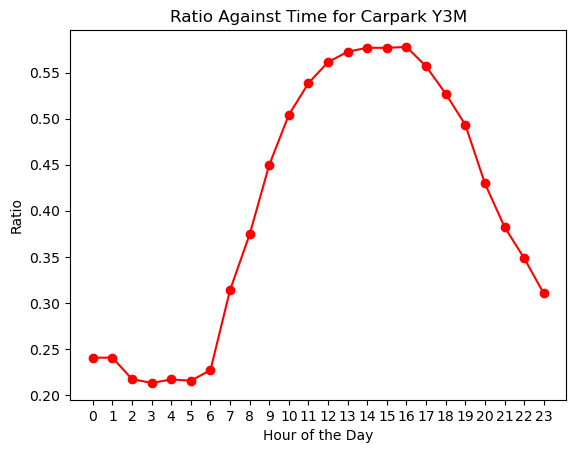

================================== Starting model generation for Carpark Y4... ==================================
File at path (./json_files/parking_Y4_train.json) already exists, loading from file.
File at path (./json_files/parking_Y4_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.00034193091975364244, R2: 0.9850059192045656
[Cross Validation on Train] Mean R2 = 0.9749, Std = 0.0143
[Test] MSE: 0.0006590816871611462, R2: 0.9656976006970817


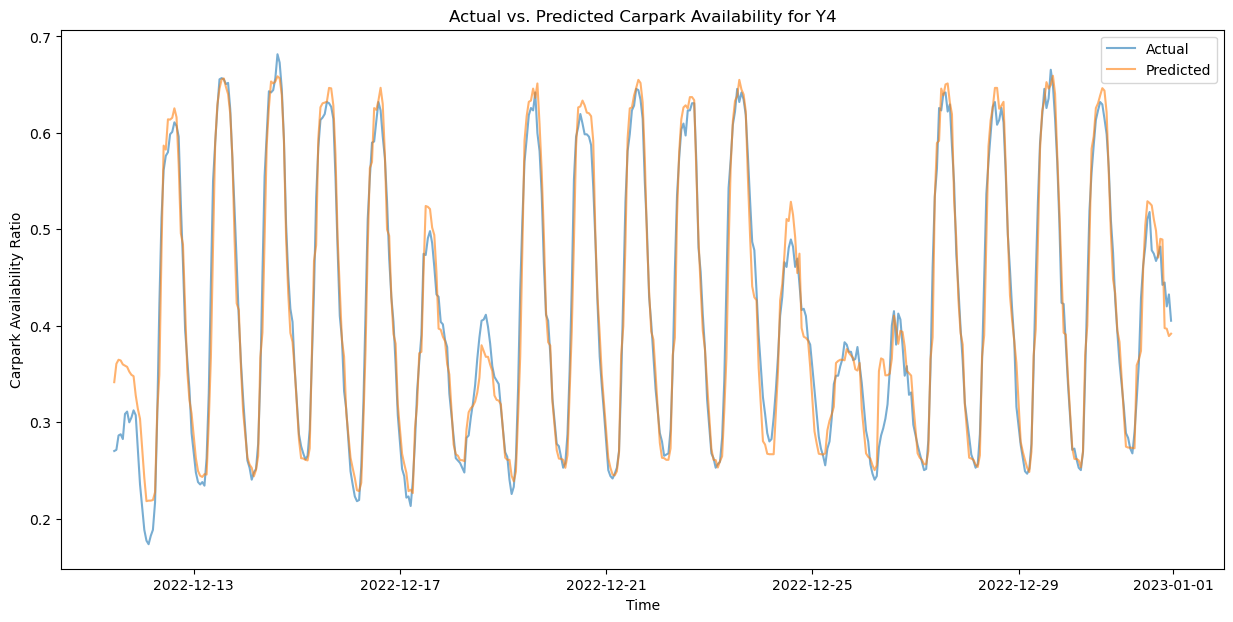

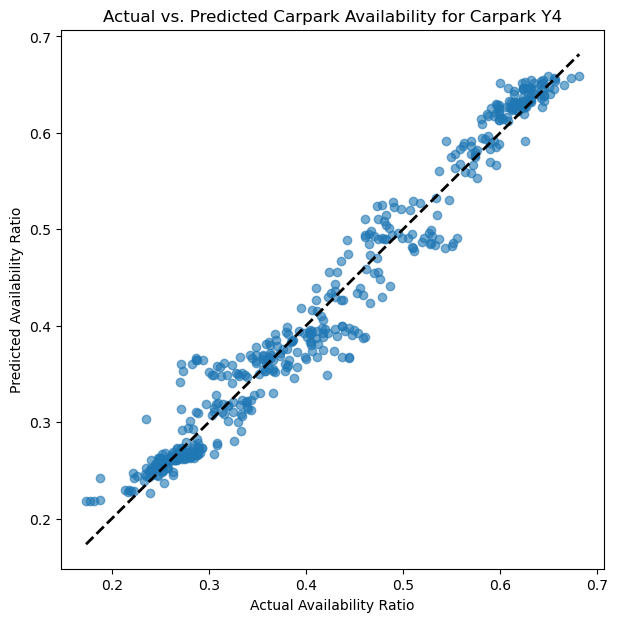

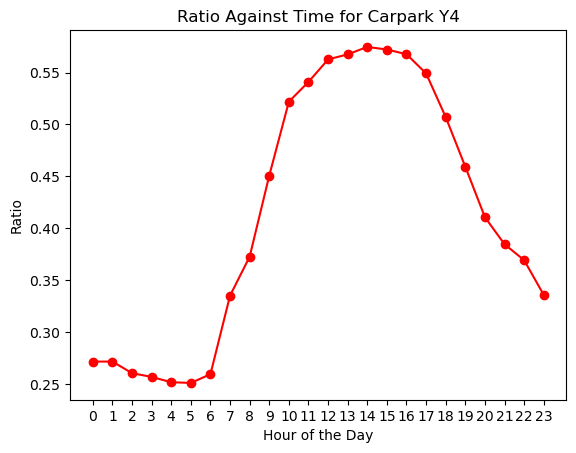

================================== Starting model generation for Carpark Y5... ==================================
File at path (./json_files/parking_Y5_train.json) already exists, loading from file.
File at path (./json_files/parking_Y5_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.000967209640952795, R2: 0.9630766089794229
[Cross Validation on Train] Mean R2 = 0.8682, Std = 0.1127
[Test] MSE: 0.0008915405299434423, R2: 0.948006752293454


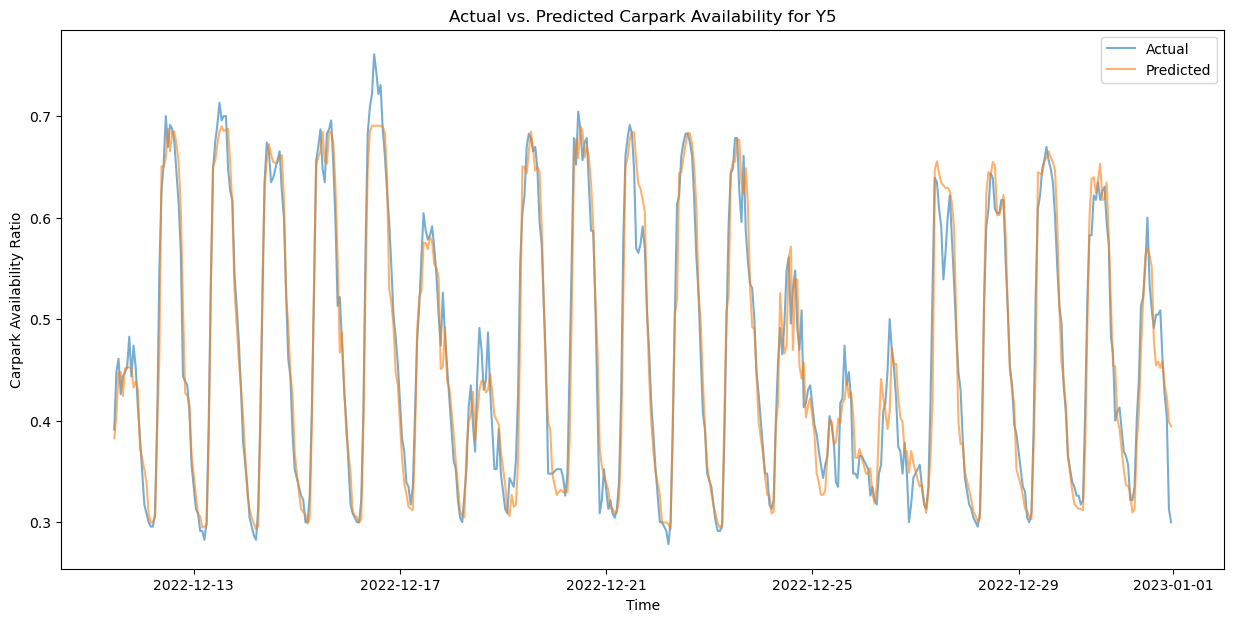

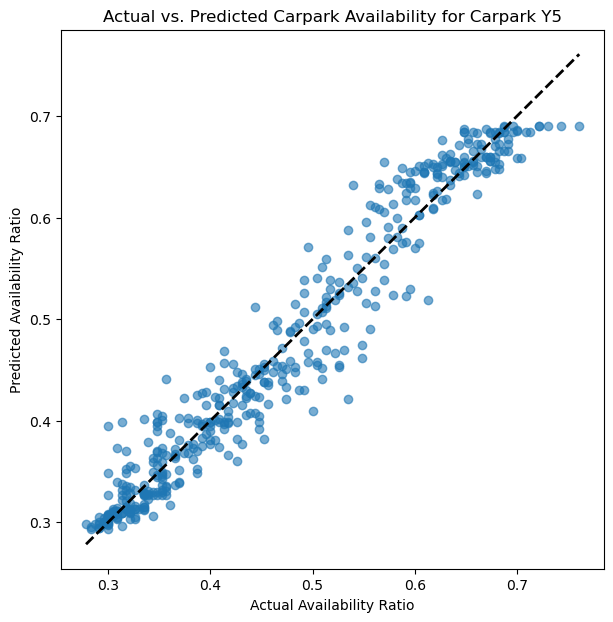

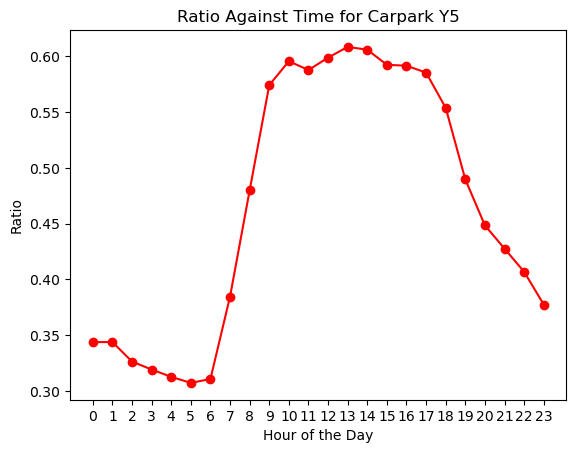

================================== Starting model generation for Carpark Y58... ==================================
File at path (./json_files/parking_Y58_train.json) already exists, loading from file.
File at path (./json_files/parking_Y58_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.003830906582948257, R2: 0.9238722770233141
[Cross Validation on Train] Mean R2 = 0.8757, Std = 0.0364
[Test] MSE: 0.003964883220975165, R2: 0.883513349268133


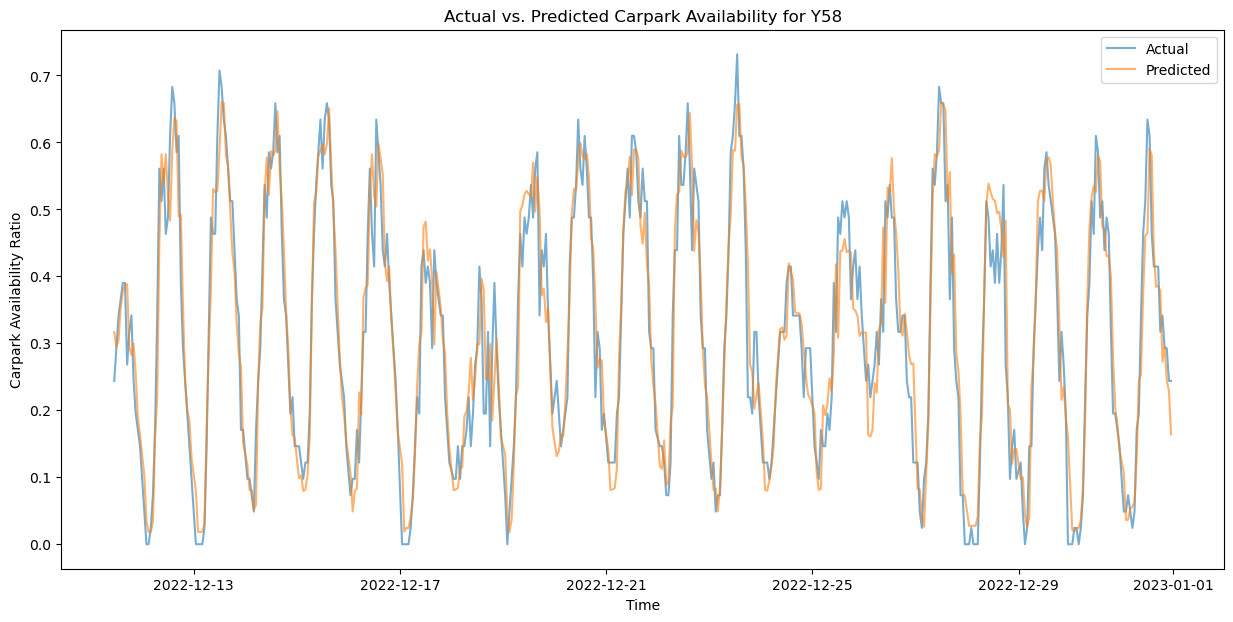

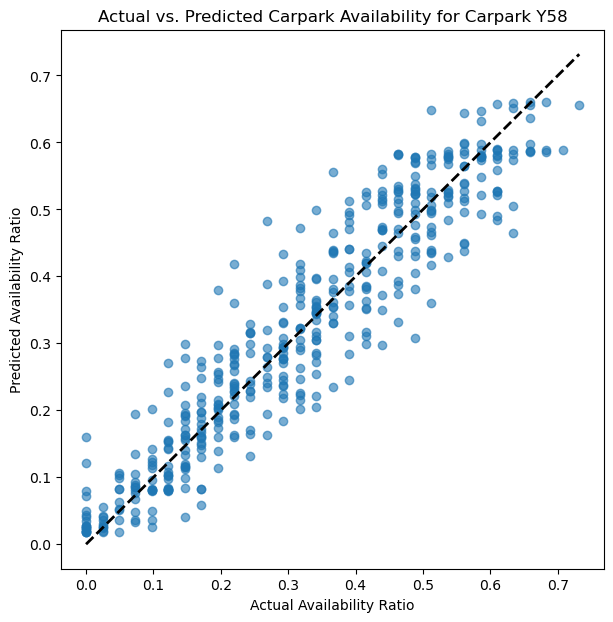

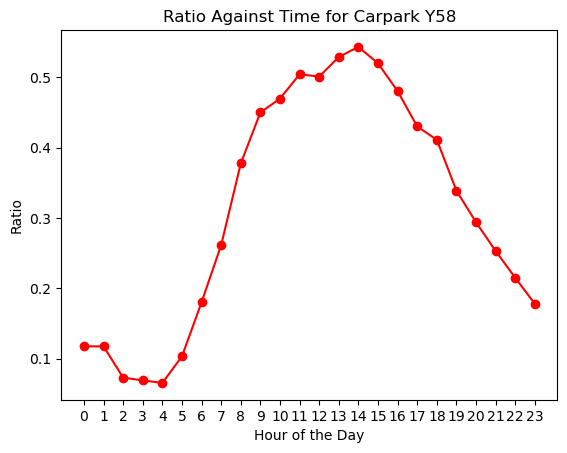

================================== Starting model generation for Carpark Y7... ==================================
File at path (./json_files/parking_Y7_train.json) already exists, loading from file.
File at path (./json_files/parking_Y7_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0005976864368826073, R2: 0.9730167403423893
[Cross Validation on Train] Mean R2 = 0.9434, Std = 0.0484
[Test] MSE: 0.0006018424287069443, R2: 0.9640769619332161


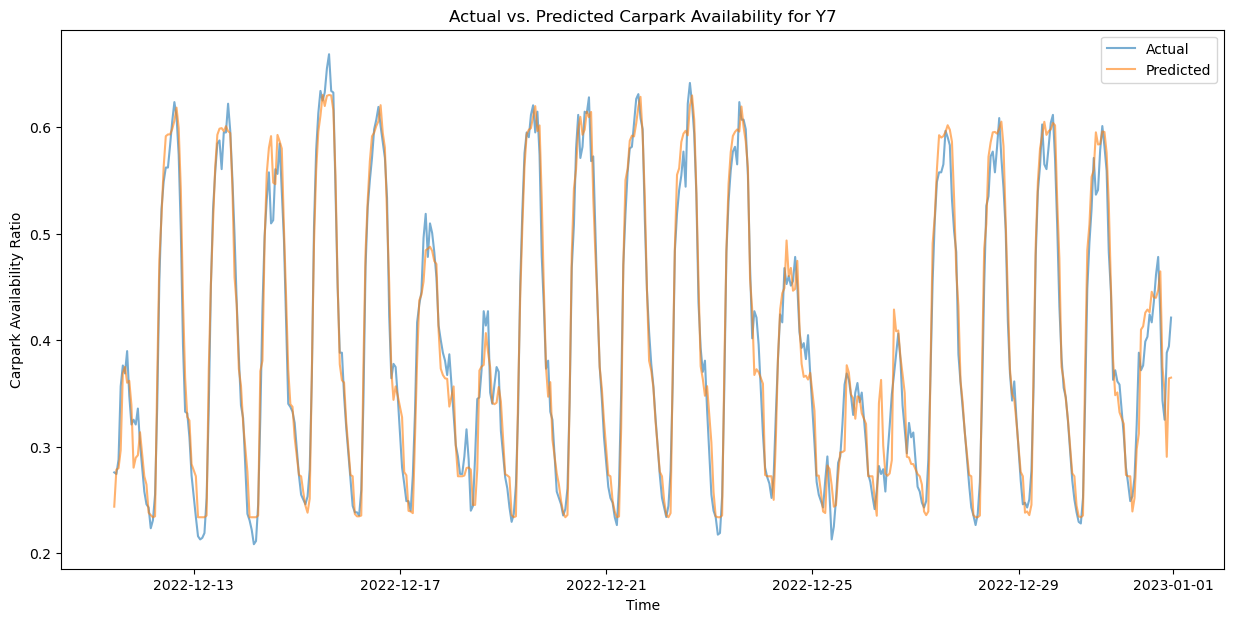

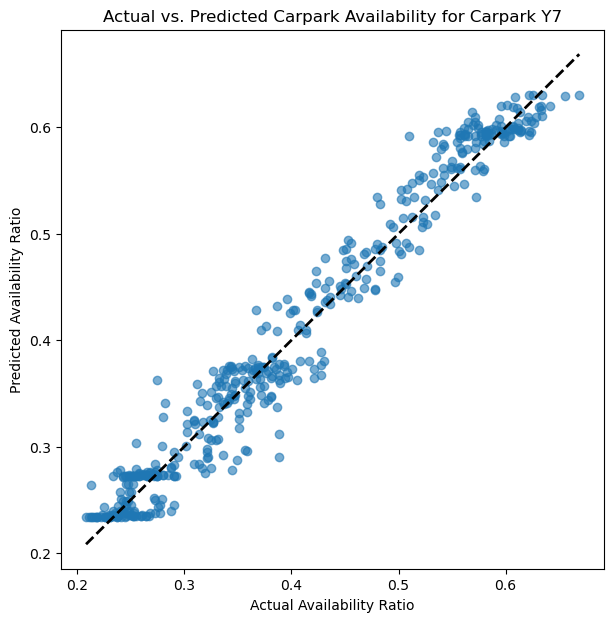

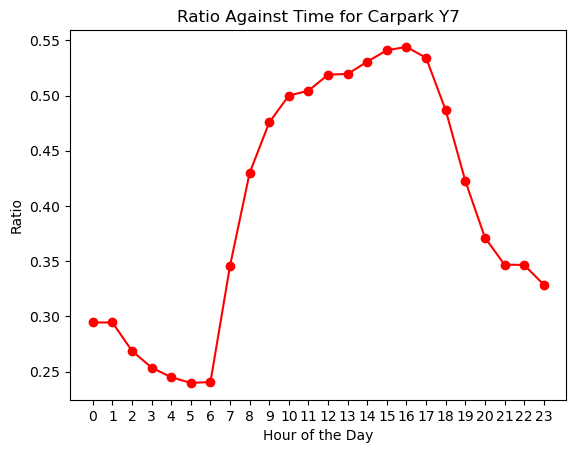

================================== Starting model generation for Carpark Y8... ==================================
File at path (./json_files/parking_Y8_train.json) already exists, loading from file.
File at path (./json_files/parking_Y8_test.json) already exists, loading from file.
Regression Metrics:
[Train] MSE: 0.0004464676911203661, R2: 0.9632149614169747
[Cross Validation on Train] Mean R2 = 0.8775, Std = 0.1486
[Test] MSE: 0.0003813876939491677, R2: 0.9459728729032141


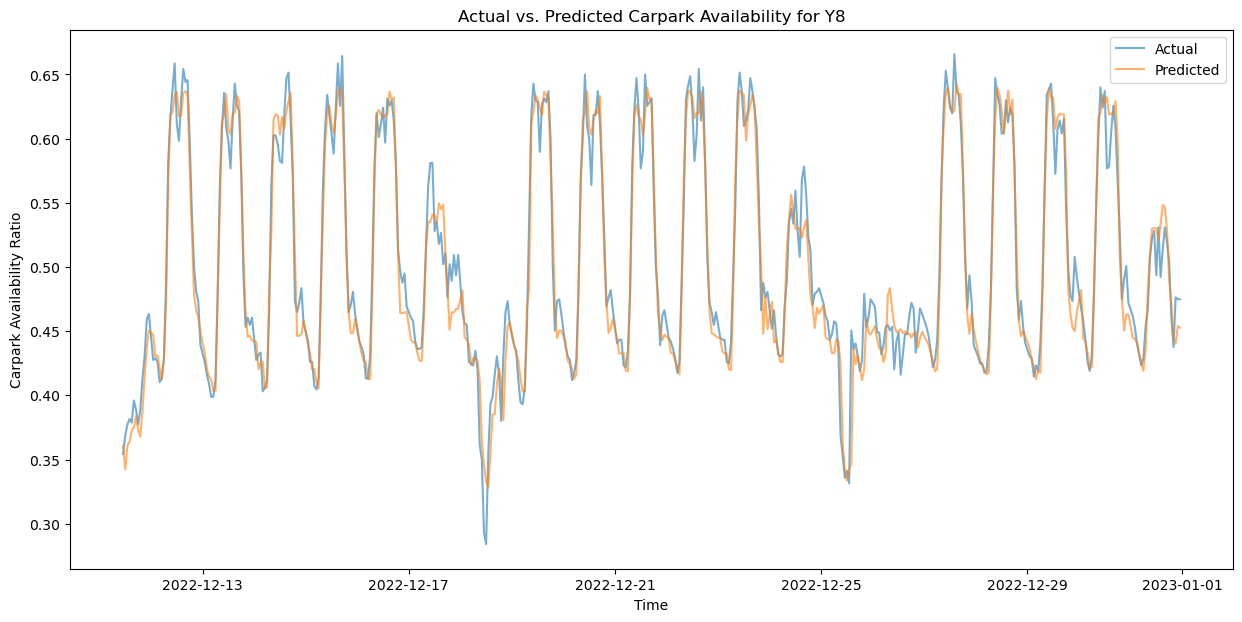

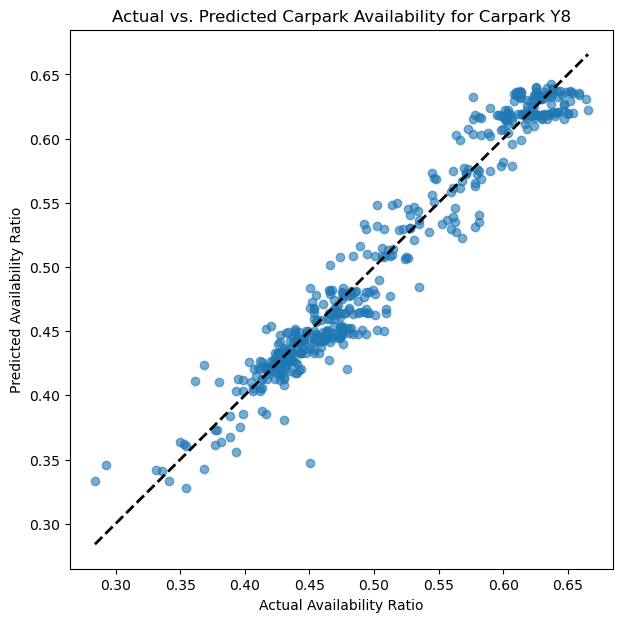

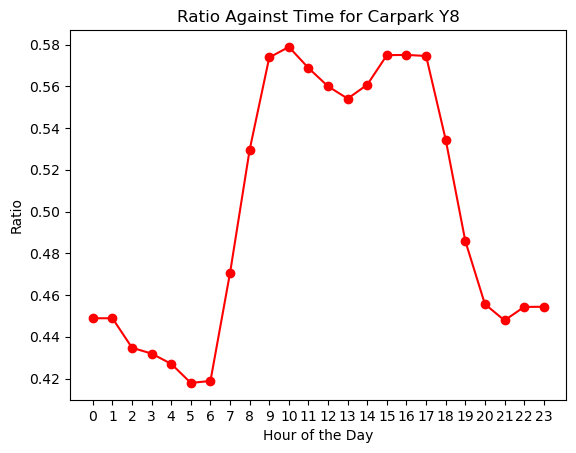

In [28]:
import time
list_of_carparks = ["Y1", "Y2", "Y3", "Y3M", "Y4", "Y5", "Y58", "Y7", "Y8"]
tot_df = pd.DataFrame()


for i in list_of_carparks:
  print(f'================================== Starting model generation for Carpark {i}... ==================================')
  dataframe_train = extract_parking_data(df_train, i, name="train")
  dataframe_test = extract_parking_data(df_test, i, name="test")
  (X_train, y_train, X_test, y_test) = gen_sets(dataframe_train, dataframe_test)
  pred_test = RandomForest(X_train, y_train, X_test, y_test)
  visualization(X_test, y_test, pred_test, i)
  df = gen_availability(pred_test, y_test, i)
  tot_df = pd.concat([tot_df, df], ignore_index = True)

### Part 8: Generate Heatmap

Heatmaps are generated as HTML files which can be accessed for viewing.

In [ ]:
import folium
from folium import plugins
from branca.element import Figure

# Latitude and longitude of Hawker center we plan on doing our analysis on (Chong Pang Hawker Center).
hawker_lat = 1.43145
hawker_lng = 103.82854

carparks = pd.read_json(f'{json_path}/nearby.json')
carpark_points = []
carpark_data = []
for num in range(carparks.shape[0]):
  if carparks.iloc[num]["Id"] in list_of_carparks:
    location = carparks.iloc[num]["location"]
    locs = location.split(" ")
    coord = (float(locs[0]), float(locs[1]))
    carpark_points.append(coord)
    carpark_data.append((coord, carparks.iloc[num]["Id"]))


def map_carparks(array, dataframe):
    # Create figure.
    fig = Figure(width = 550, height = 350)

    # Add map to figure.
    centroidMap = folium.Map(width = 550, height = 350,
                   location = [hawker_lat, hawker_lng],
                   zoom_start = 15, min_zoom = 15, max_zoom = 15)
    fig.add_child(centroidMap)

    folium.Marker(
            location=[hawker_lat, hawker_lng],
            popup="Chong Pang Hawker Center",
            icon=folium.Icon(color="green", icon="info-sign"),
        ).add_to(centroidMap)

    for carpark in array:
        point = carpark[0]
        id = carpark[1]
        folium.Marker(
            location=[point[0], point[1]],
            popup=id,
            icon=folium.Icon(color="red", icon="info-sign"),
        ).add_to(centroidMap)

    plugins.HeatMap(df_heatmap, radius = 25, blur = 20).add_to(centroidMap)
    return fig

for i in range(24):
  df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
  df_heatmap = pd.concat([df_heatmap, tot_df[f"hour {i} ratio"] * 200], ignore_index=True, axis=1)

  figure = map_carparks(carpark_data, df_heatmap)

  if not os.path.exists(heatmaps_path):
    os.makedirs()

  figure.save(f"{heatmaps_path}/heatmap_{i}.html")

#### 8.1 Sample Heatmaps

2 sample heatmaps are generated in the cells below. The red icons are the Carparks in the area, while the green icon is the Hawker Centre that we are conducting the analysis around.

In [ ]:
# Sample Heatmap at 12pm around Chong Pang Food Court:
df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
df_heatmap = pd.concat([df_heatmap, tot_df[f"hour 12 ratio"] * 200], ignore_index=True, axis=1)

figure = map_carparks(carpark_data, df_heatmap)
figure

In [ ]:
# Sample Heatmap at 12am around Chong Pang Food Court:
df_heatmap = pd.DataFrame(carpark_points, columns=["latitude", "longitude"])
df_heatmap = pd.concat([df_heatmap, tot_df[f"hour 0 ratio"] * 200], ignore_index=True, axis=1)

figure = map_carparks(carpark_data, df_heatmap)
figure

## Question 3 Analysis
In our project, we are examining car park spaces in relation to the time of day and their proximity to popular hawker centers. We start by analyzing a dataset from data.gov.sg, which shows the availability of car parks. This data reveals a general trend: early in the morning, around 5 AM, the availability of car parks is at about 45%. As the day progresses, this number slowly increases in a pattern that looks like a U-shaped curve. By 4 PM, the availability usually reaches its peak at 65%, and then it starts decreasing again, following a similar curve, until it goes back to 45% at around 4 AM the next day.

Since we cannot know for sure how car park availability changes every minute of the day, we use Machine Learning as a tool to predict these changes. Machine Learning helps us estimate the availability based on the hour, using models designed for predicting numbers, like Decision Trees, Support Vector Machines, Random Forests, and more advanced techniques like Ensembling and Adaptive Boosting (AdaBoostRegressor).

To add another layer to our analysis, we cross-reference the car park codes with the DataMall API to find their exact locations. We then gather data on hawker centers from a GEOJSON file on data.gov.sg and pinpoint their locations too.

Our focus then shifts to identifying car parks that are within 200 meters of these hawker centers. We create a new dataset, 'hawker_nearby.json', which links car parks to nearby hawker centers. For example, we found that the Bukit Merah Central Food Centre has several car parks in its vicinity, each with its own ID, address, and coordinates.

```
"Bukit Merah Central Blk 163 (Bukit Merah Central Food Centre)": [
        {
            "carpark_id": "HE12",
            "carpark_add": "BLK 78/81 REDHILL LANE",
            "carpark_coord": "1.2882100231309097 103.81865062406243"
        },
        {
            "carpark_id": "RHM",
            "carpark_add": "BLK 88A REDHILL CLOSE",
            "carpark_coord": "1.2864639274816887 103.81857760519375"
        },
        {
            "carpark_id": "BM29",
            "carpark_add": "BLK 163 BUKIT MERAH CENTRAL",
            "carpark_coord": "1.283634706091155 103.81709921259974"
        }]
  ```

By combining these datasets, we can understand how car park availability correlates with the proximity to hawker centers, particularly during meal times. This analysis is valuable in the context of a data science project because it provides insights into urban planning and public convenience. It helps to answer questions like: How does the demand for car parks change throughout the day? Are there enough parking spaces near popular dining areas? This understanding could guide city planners in improving parking solutions and managing traffic better, especially during peak dining hours.

In conclusion, our project expands beyond the initial proposal by integrating different datasets and applying Machine Learning to draw meaningful conclusions about car park availability in relation to hawker centers. This approach demonstrates the power of data science in solving real-world problems and improving everyday life.


## Question 3 Practical Action

We've created a dynamic heatmap to show car park availability near hawker centres. This approach simplifies parking for drivers, making it easier to find spots in urban areas.

The heatmap, integrated into a user-friendly app, aims to reduce the time and fuel spent on searching for parking, thereby easing traffic congestion. This efficient parking solution can lessen the burden on city infrastructure and promote sustainable urban living.

Our model provides detailed information on individual car parks rather than generalizing across multiple locations. This specificity helps drivers avoid crowded areas and find available parking near busy dining spots. This not only evenly distributes parked cars but also streamlines the dining experience, connecting users quickly with their desired destinations.

Using data to enhance urban navigation and convenience, we aim to make city life easier and more efficient for Singaporeans.